In [1]:
import warnings
warnings.filterwarnings('ignore')
# import cv2
import numpy as np
import glob
import random
from skimage.io import imread, imshow, imread_collection, concatenate_images
from matplotlib import pyplot as plt
from keras.models import load_model
import segmentation_models as sm

seed = 56

IMAGE_HEIGHT = IMAGE_WIDTH = 256 * 2 # * 2

BATCH_SIZE = 4

ROOT = "./../Data/all-cities/"
TEST_DIR = "_Test512/"

Segmentation Models: using `keras` framework.


In [2]:
from PIL import Image

test_images = np.array([np.array(Image.open(fname)) for fname in glob.glob(ROOT + TEST_DIR + 'Images/samples/*')])
test_masks = np.array([np.array(Image.open(fname).convert('L')) for fname in glob.glob(ROOT + TEST_DIR + 'Masks/samples/*')]) # convert to lose two channels


In [2]:
import get_data_generators

augmentation = {
}

test_gen = get_data_generators.getDataGenerators(augmentation, (IMAGE_WIDTH, IMAGE_HEIGHT), test_images_path=ROOT + TEST_DIR + "Images", test_targets_path=ROOT + TEST_DIR + "Masks", batch_size=BATCH_SIZE, seed=seed)
test_gen = test_gen[0]

Found 1771 images belonging to 1 classes.
Found 1771 images belonging to 1 classes.


In [3]:
import metric

model_path = "./../Models/Binary/512/bike_mapper_pre-train-scratch-resnet34_Train3607_Val313_Test980_No-Aug.h5"
modelEval = load_model(model_path, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.1), "f1-score":sm.metrics.FScore(), "quality": metric.quality()})

met = modelEval.metrics[1:] #+ [metric.quality()] # [1:] to not include loss

modelEval.compile(optimizer=modelEval.optimizer, loss=modelEval.loss, metrics= met, run_eagerly=True)

In [4]:
modelEval.evaluate(test_gen.data, steps=test_gen.samplesPerBatch)

245/245 [==============================] - 50s 185ms/step - loss: 0.5962 - iou_score: 0.2630 - f1-score: 0.4038 - quality: 0.5229


[0.5961654186248779,
 0.2630314230918884,
 0.40383458137512207,
 0.5228685736656189]

In [5]:
predictions = modelEval.predict(test_gen.data, steps=test_gen.samplesPerBatch)

245/245 [==============================] - 16s 53ms/step


In [3]:
import inference

pred = inference.predict(modelEval, 'C:/Users/domin/Desktop/test-karlsruhe.tif') # "C:/Users/domin/Desktop/gitrepos/detector/Data/Hannover/_Test512/Images/samples/14_dop20rgb_32_546_5800_2_ni_2019-04-08.tif")
print(pred)

(512, 512, 3)
1/1 [==============================] - 3s 3s/step
[  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  18  21
  22  23  24  25  27  30  31  32  33  36  37  38  39  40  43  53  57  61
  62  65  66  67  68  70  71  73  75  79  80  81  93  98 104 105 107 115
 117 125 129 130 133 134 135 143 144 146 147 149 150 152 153 157 158 168
 179 182 185 191 193 196 199 200 202 203 205 206 210 212 214 215 216 223
 224 226 227 228 229 230 231 233 236 238 239 240 241 242 243 245 246 247
 248 249 250 251 252 253 254 255] (512, 512)


ValueError: height and width must be > 0

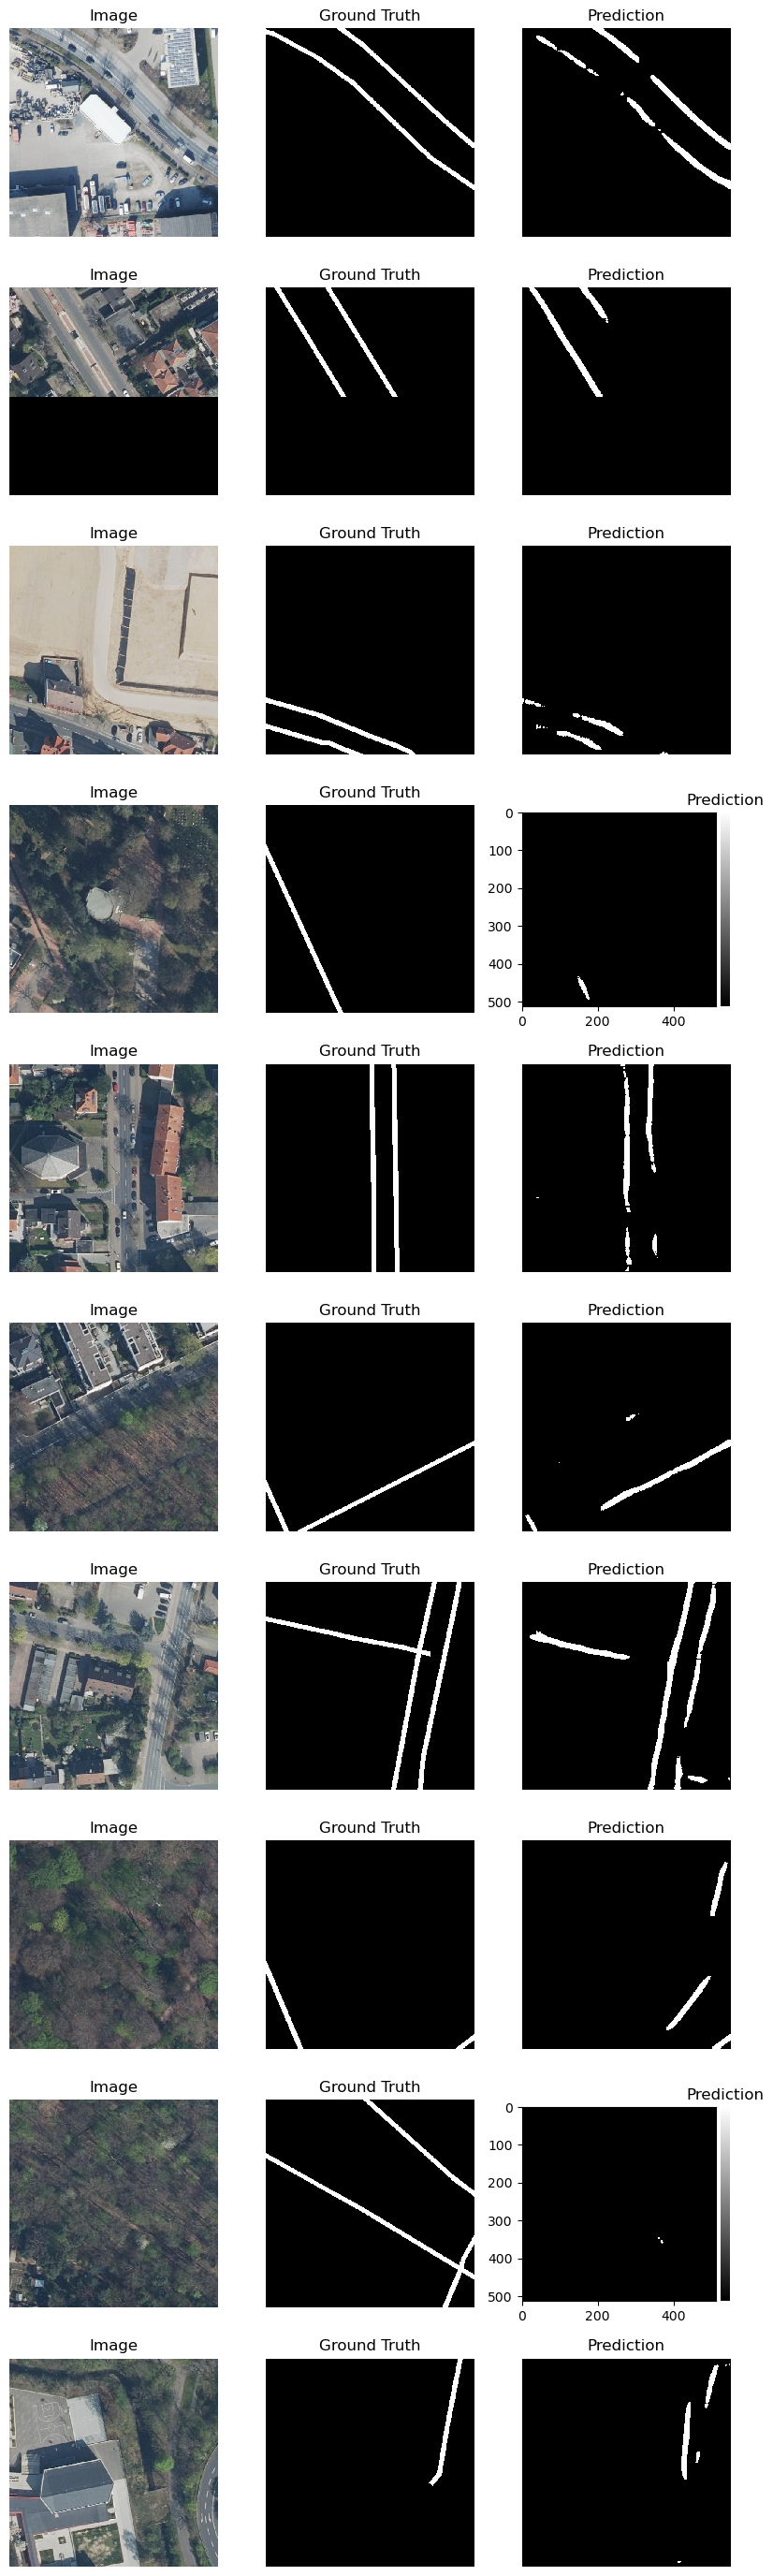

In [6]:
thresh_val = 0.1

ix = random.randint(0, len(predictions))
num_samples = 10

f = plt.figure(figsize = (8, 28))
for i in range(1, num_samples*3, 3):
  ix = random.randint(0, len(predictions))

  f.add_subplot(num_samples, 3, i)
  imshow(test_images[ix][:,:,:])
  plt.title("Image")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+1)
  show = np.squeeze(test_masks[ix][:,:])
  imshow(show)
  plt.title("Ground Truth")
  plt.axis('off')

  f.add_subplot(num_samples, 3, i+2)
  show = np.squeeze(predictions[ix][:,:,0])
  show[show < thresh_val] = 0
  show[show >= thresh_val] = 255
  show = show.astype(np.uint8)
  imshow(show, cmap="gray")
  plt.title("Prediction")
  plt.axis('off')

plt.show()

In [ ]:
# test all in directory

import metric
import os

models_files = glob.glob("./../Models/Double-Data/backbones/*.h5")
models = []

for model_path in models_files:
  if model_path[-4].isdigit():
    continue

  models.append(model_path)

print("networks to be tested:")
print(models)

for model_path in models:
  print("testing", model_path)

  modelEval = load_model(model_path, custom_objects={"dice_loss" : sm.losses.DiceLoss(), "iou_score": sm.metrics.IOUScore(threshold=0.1), "f1-score":sm.metrics.FScore(), "quality": metric.quality()})

  met = modelEval.metrics[1:] #+ [metric.quality()] # [1:] to not include loss

  modelEval.compile(optimizer=modelEval.optimizer, loss=modelEval.loss, metrics= met, run_eagerly=True)

  _, iou, _, quality = modelEval.evaluate(test_gen.data, steps=test_gen.samplesPerBatch)

  iou, quality = round(iou * 10_000), round(quality * 10_000)

  insertion = "_IoU" + str(iou) + "_q" + str(quality)
  os.rename(model_path, model_path[:-3] + insertion + ".h5")
  os.rename(model_path[:-3] + "__iou.png", model_path[:-3] + insertion + "__iou.png")
  os.rename(model_path[:-3] + "__quality.png", model_path[:-3] + insertion + "__quality.png")


networks to be tested:
['./../Models/Double-Data/backbones\\bike_mapper_pre-train-scratch-densenet121_Aug.h5', './../Models/Double-Data/backbones\\bike_mapper_pre-train-scratch-inceptionv3_Aug.h5', './../Models/Double-Data/backbones\\bike_mapper_pre-train-scratch-vgg16_Aug.h5']
testing ./../Models/Double-Data/backbones\bike_mapper_pre-train-scratch-densenet121_Aug.h5
442/442 [==============================] - 461s 1s/step - loss: 0.5395 - iou_score: 0.3076 - f1-score: 0.4605 - quality: 0.6178
testing ./../Models/Double-Data/backbones\bike_mapper_pre-train-scratch-inceptionv3_Aug.h5
442/442 [==============================] - 435s 968ms/step - loss: 0.5637 - iou_score: 0.2876 - f1-score: 0.4363 - quality: 0.5974
testing ./../Models/Double-Data/backbones\bike_mapper_pre-train-scratch-vgg16_Aug.h5
219/442 [=============>................] - ETA: 3:20 - loss: 0.5492 - iou_score: 0.2999 - f1-score: 0.4508 - quality: 0.6052